In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd
import scipy.stats as st
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras import layers, models, optimizers
from keras.applications import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.callbacks import Callback
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Note the following code as been built in collaboration with GPT-4.
# OpenAI. (2023). ChatGPT (Mar 23 version) [Large language model]. https://chat.openai.com/c/b1498a7b-afc7-49e7-bd55-b90f0b9922b3

In [ ]:
drive.mount('/content/drive')

# Load the CSV files
metadata_df = pd.read_csv('/content/drive/My Drive/Project/archive/HAM10000_metadata.csv')

# Add the .jpg file extension to the filenames in the dataframe
metadata_df['image_id'] = metadata_df['image_id'].apply(lambda x: f"{x}.jpg")

# Define image directories
data_dir_1 = '/content/drive/My Drive/Project/archive/HAM10000_images_part_1'
data_dir_2 = '/content/drive/My Drive/Project/archive/HAM10000_images_part_2'

# Merge the two image directories
metadata_df['image_path'] = metadata_df['image_id'].apply(lambda x: os.path.join(data_dir_1, x) if os.path.exists(os.path.join(data_dir_1, x)) else os.path.join(data_dir_2, x))

# Create a stratified train and validation split 
train_df, valid_df = train_test_split(metadata_df, test_size=0.15, random_state=47, stratify=metadata_df['dx'])

# Reset the index of the resulting dataframes
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)


Mounted at /content/drive


In [ ]:
# Looking for similar ratio in the val and train data
train_class_counts = train_df['dx'].value_counts()
print("~Train classes~")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} samples")
print("\n ~Val classes~")
val_class_counts = valid_df['dx'].value_counts()
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} samples")

~Train classes~
nv: 5699 samples
mel: 946 samples
bkl: 934 samples
bcc: 437 samples
akiec: 278 samples
vasc: 120 samples
df: 98 samples

 ~Val classes~
nv: 1006 samples
mel: 167 samples
bkl: 165 samples
bcc: 77 samples
akiec: 49 samples
vasc: 22 samples
df: 17 samples


In [ ]:
# Load Inception v3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# We fine-tune all layer
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
# Remove the last layer
x = base_model.output

# Add out final layer for classification
# Set number of class to 7 as we only have 7 labels in our data
number_of_classes = 7

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(number_of_classes, activation='softmax')(x)

# Modifying Model
model = models.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Define a learning rate scheduler with a decay factor 
def lr_schedule(epoch, lr):
    decay_factor = 16
    decay_epoch = 16
    if epoch > 0 and epoch / 30 == 0:
        return lr / decay_factor
    return lr

In [ ]:
# Compile the model with RMSProp optimizer and the specified parameters
model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batchSize = 32

sampling_strategy = {
    'nv': 1000,
    'mel': 946,
    'bkl': 934,
    'bcc': 437,
    'akiec': 278,
    'vasc': 120,
    'df': 98 
}

# Custom preprocessing function
def custom_preprocessing_function(image):
    def crop_largest_inscribed_rect(image, angle):
        h, w = image.shape[:2]
        angle = angle % 360

        if angle > 180:
            angle = 360 - angle

        angle_rad = np.deg2rad(angle)

        if w > h:
            h, w = w, h

        new_w = int(h * np.abs(np.cos(angle_rad)) + w * np.abs(np.sin(angle_rad)))
        new_h = int(h * np.abs(np.sin(angle_rad)) + w * np.abs(np.cos(angle_rad)))

        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        rotated = cv2.warpAffine(image, M, (w, h))
        cropped = rotated[(h - new_h) // 2:(h + new_h) // 2, (w - new_w) // 2:(w + new_w) // 2]

        return cropped

    angle = np.random.randint(0, 360)
    rotated_and_cropped = crop_largest_inscribed_rect(image, angle)
    resized = cv2.resize(rotated_and_cropped, (299, 299))

    if np.random.rand() > 0.5:
        flipped = cv2.flip(resized, 0)
    else:
        flipped = resized

    rescaled = flipped / 255.0
    return rescaled

def load_images(image_paths, target_size):
    images = []
    for img_path in image_paths:
        img = keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    return np.array(images)

class UndersamplingDataGenerator(Sequence):
    def __init__(self, dataframe, x_col, y_col, datagen, target_size, batch_size, undersampler):
        self.original_dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.datagen = datagen
        self.target_size = target_size
        self.batch_size = batch_size
        self.undersampler = undersampler
        self.all_classes = np.unique(dataframe[y_col])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / float(self.batch_size)))

    def __data_generation(self, image_paths, labels):
        X = load_images(image_paths, target_size=self.target_size)
        y = pd.get_dummies(labels).reindex(columns=self.all_classes, fill_value=0).values

        # Apply the custom preprocessing function
        for i, img in enumerate(X):
            X[i] = custom_preprocessing_function(img)

        return X, y

    def __getitem__(self, idx):
        batch_x = self.dataframe.iloc[idx * self.batch_size:(idx + 1) * self.batch_size, self.dataframe.columns.get_loc(self.x_col)].values
        batch_y = self.dataframe.iloc[idx * self.batch_size:(idx + 1) * self.batch_size, self.dataframe.columns.get_loc(self.y_col)].values

        X, y = self.__data_generation(batch_x, batch_y)
        return X, y

    def on_epoch_end(self):
        self.dataframe = shuffle(self.original_dataframe)

        X, y = self.dataframe[self.x_col].values, self.dataframe[self.y_col].values
        X, y = self.undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

        self.dataframe = pd.DataFrame({self.x_col: X.flatten(), self.y_col: y})
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

# Create the train and validation generators
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator(rescale=1./255)
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=47)

train_generator = UndersamplingDataGenerator(train_df, 'image_path', 'dx', train_datagen, (299, 299), batchSize, undersampler)
valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,
                                                     x_col='image_path',
                                                     y_col='dx',
                                                     target_size=(299, 299),
                                                     batch_size=batchSize,
                                                     class_mode='categorical')

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.Paper', monitor='val_loss', save_best_only=True, mode='min')
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

Found 1503 validated image filenames belonging to 7 classes.


In [ ]:
# Train the model
total_epochs = 20

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=total_epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n // valid_generator.batch_size,
                    callbacks=[early_stopping, lr_callback, model_checkpoint])

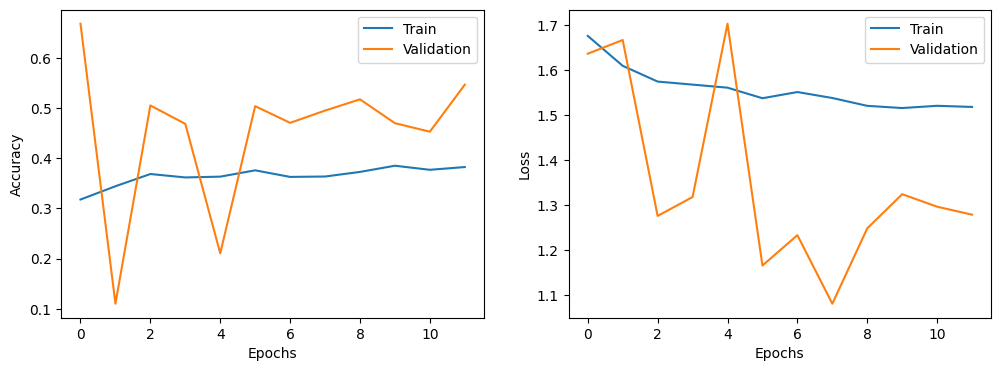

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/My Drive/Project/v3.epoch20.batch32.Paper')

------------------------------------------------------------------------
We can use the following chunks to test the model on individual samples.

In [ ]:
model = load_model('/content/drive/My Drive/Project/v3.epoch20.batch32.Paper')

In [ ]:
import pandas as pd

# Load the CSV file
metadata_test = pd.read_csv('/content/drive/My Drive/Project/archive/ISIC2018_Task3_Test_GroundTruth.csv')

# Define image directories
test_dir = '/content/drive/My Drive/Project/archive/ISIC2018_Task3_Test_Input'

# Rename the 'image' column to 'image_id' and add the '.jpg' extension
metadata_test['image_id'] = metadata_test['image'] + '.jpg'
metadata_test.drop(columns=['image'], inplace=True)

# Create a new column 'image_path' with the complete path to each image file
metadata_test['image_path'] = metadata_test['image_id'].apply(lambda x: os.path.join(test_dir, x))

# Convert the one-hot encoded class columns to numeric values
class_columns = metadata_test.columns[:-1]
metadata_test[class_columns] = metadata_test[class_columns].apply(pd.to_numeric, errors='coerce')

# Find the class name (column name) with the highest value (one-hot encoding) and store it in a new column 'dx'
metadata_test['dx'] = metadata_test[class_columns].idxmax(axis=1)

# Convert the class names in 'dx' column to lowercase
metadata_test['dx'] = metadata_test['dx'].str.lower()

metadata_test.drop(columns=['image_id'], inplace=True)

# Define image generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=metadata_test,
    directory=test_dir,
    x_col='image_path',
    y_col='dx',
    target_size=(299, 299),
    batch_size=batch_size,
    shuffle=False
)

Found 1512 validated image filenames belonging to 7 classes.


1/1 [==============================] - 3s 3s/step


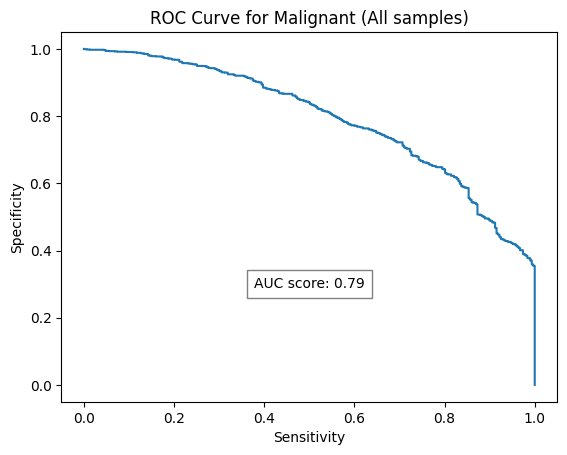

AUC score is 0.7925946450052036


In [ ]:
def get_true_and_predicted_labels(model, generator):
    true_labels = []
    predicted_probs = []

    for i in range(generator.__len__()):
        X_batch, y_batch_true = generator.__getitem__(i)
        y_batch_pred = model.predict(X_batch)

        true_labels.extend(np.argmax(y_batch_true, axis=1))
        predicted_probs.extend(y_batch_pred)

    return np.array(true_labels), np.array(predicted_probs)

y_true, y_pred = get_true_and_predicted_labels(model, test_generator)

# Create binary scores for malignant and benign classes
benign_score = y_pred[:, ~np.isin(np.arange(y_pred.shape[1]), malignant_classes_indices)].sum(axis=1)
mal_score = y_pred[:, malignant_classes_indices].sum(axis=1)

binary_truth = np.array([1 if label in malignant_classes_indices else 0 for label in y_true])

# Calculate the AUC
auc_score = roc_auc_score(binary_truth, mal_score)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(binary_truth, mal_score, pos_label=1)
sensitivity = tpr
specificity = 1 - fpr

# Plot the ROC curve
plt.plot(sensitivity, specificity)
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("ROC Curve for Malignant (All samples)")
plt.text(0.5, 0.3, f"AUC score: {auc_score:.2f}", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', pad=5.0))
plt.show()

print("AUC score is " + str(auc_score))

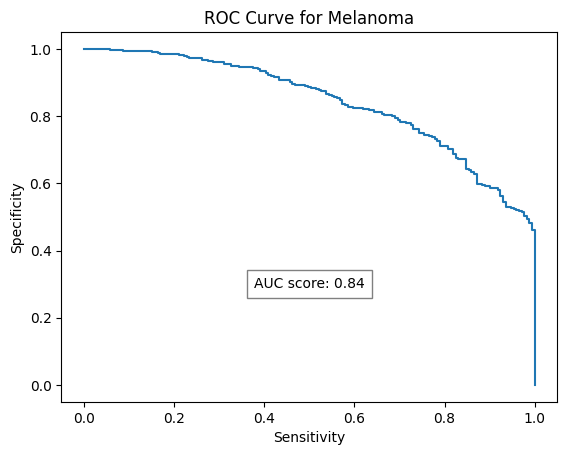

In [ ]:
# Get class indices for 'mel' and 'nv' classes
mel_class_index = test_generator.class_indices['mel']
nv_class_index = test_generator.class_indices['nv']

# Filter samples belonging to 'mel' and 'nv' classes
mel_nv_indices = np.where((y_true == mel_class_index) | (y_true == nv_class_index))
y_true_filtered = y_true[mel_nv_indices]
y_pred_filtered = y_pred[mel_nv_indices]

# Create binary scores for malignant and benign classes
benign_score = y_pred_filtered[:, ~np.isin(np.arange(y_pred_filtered.shape[1]), malignant_classes_indices)].sum(axis=1)
mal_score_mel_nv = y_pred_filtered[:, malignant_classes_indices].sum(axis=1)

binary_truth_mel_nv = np.array([1 if label in malignant_classes_indices else 0 for label in y_true_filtered])

# Calculate the AUC
auc_score = roc_auc_score(binary_truth_mel_nv, mal_score_mel_nv)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(binary_truth_mel_nv, mal_score_mel_nv, pos_label=1)
sensitivity = tpr
specificity = 1 - fpr

# Plot the ROC curve
plt.plot(sensitivity, specificity)
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("ROC Curve for Melanoma")
plt.text(0.5, 0.3, f"AUC score: {auc_score:.2f}", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', pad=5.0))
plt.show()

Text(0.5, 0.3, 'AUC score: 0.64')

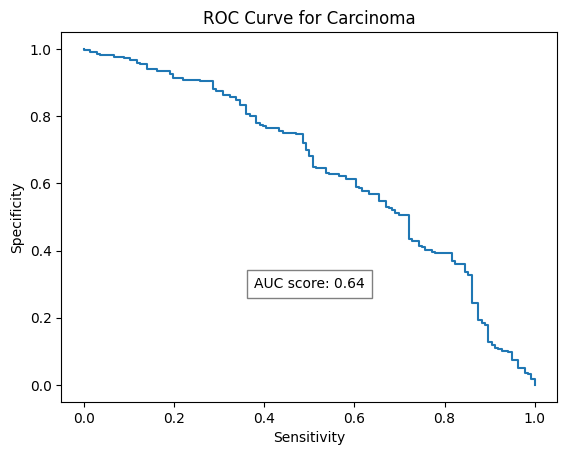

In [ ]:
# Get class indices for 'bkl', 'akiec' and 'bcc' classes
bkl_class_index = test_generator.class_indices['bkl']
akiec_class_index = test_generator.class_indices['akiec']
bcc_class_index = test_generator.class_indices['bcc']

# Filter samples belonging to 'bkl', 'akiec' and 'bcc' classes
indices = np.where((y_true == bkl_class_index) | 
                   (y_true == akiec_class_index) | (y_true == bcc_class_index))
y_true_filtered = y_true[indices]
y_pred_filtered = y_pred[indices]

# Create binary scores for malignant and benign classes
benign_score = y_pred_filtered[:, ~np.isin(np.arange(y_pred_filtered.shape[1]), malignant_classes_indices)].sum(axis=1)
mal_score = y_pred_filtered[:, malignant_classes_indices].sum(axis=1)

binary_truth = np.array([1 if label in malignant_classes_indices else 0 for label in y_true_filtered])

# Calculate the AUC
auc_score = roc_auc_score(binary_truth, mal_score)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(binary_truth, mal_score, pos_label=1)
sensitivity = tpr
specificity = 1 - fpr

# Plot the ROC curve
plt.plot(sensitivity, specificity)
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("ROC Curve for Carcinoma")
plt.text(0.5, 0.3, f"AUC score: {auc_score:.2f}", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', pad=5.0))

In [ ]:
def get_true_and_predicted_labels(model, generator):
    true_labels = []
    predicted_labels = []
    
    for i in range(generator.__len__()):
        X_batch, y_batch_true = generator.__getitem__(i)
        y_batch_pred = model.predict(X_batch)
        y_batch_true_labels = np.argmax(y_batch_true, axis=1)
        y_batch_pred_labels = np.argmax(y_batch_pred, axis=1)
        
        true_labels.extend(y_batch_true_labels)
        predicted_labels.extend(y_batch_pred_labels)
    
    return np.array(true_labels), np.array(predicted_labels)

def compute_accuracy_and_confidence_interval(y_true, y_pred, alpha=0.95):
    accuracy = accuracy_score(y_true, y_pred)
    n = len(y_true)
    z = st.norm.ppf(1 - (1 - alpha) / 2)
    confidence_interval = z * np.sqrt(accuracy * (1 - accuracy) / n)
    return accuracy, (accuracy - confidence_interval, accuracy + confidence_interval)

# Get the true and predicted labels
true_labels, predicted_labels = get_true_and_predicted_labels(model, test_generator)

# Get the malignant class indices
malignant_indices = [test_generator.class_indices[cls] for cls in ['akiec', 'bcc', 'mel']]

# Convert the true and predicted labels to binary (benign/malignant)
true_labels_binary = np.array([1 if label in malignant_indices else 0 for label in true_labels])
predicted_labels_binary = np.array([1 if label in malignant_indices else 0 for label in predicted_labels])

# Compute the two-way accuracy and confidence interval
two_way_accuracy, two_way_confidence_interval = compute_accuracy_and_confidence_interval(true_labels_binary, predicted_labels_binary)
print(f"Two-way accuracy: {two_way_accuracy * 100:.2f}%")
print(f"Confidence interval: {two_way_confidence_interval[0] * 100:.2f}% - {two_way_confidence_interval[1] * 100:.2f}%")

# Compute the seven-way accuracy and confidence interval
seven_way_accuracy, seven_way_confidence_interval = compute_accuracy_and_confidence_interval(true_labels, predicted_labels)
print(f"Seven-way accuracy: {seven_way_accuracy * 100:.2f}%")
print(f"Confidence interval: {seven_way_confidence_interval[0] * 100:.2f}% - {seven_way_confidence_interval[1] * 100:.2f}%")

1/1 [==============================] - 2s 2s/step
Two-way accuracy: 56.75%
Confidence interval: 54.25% - 59.24%
Seven-way accuracy: 44.51%
Confidence interval: 42.01% - 47.02%
